In [2]:
import numpy as np
import pandas as pd
import matplotlib         
import matplotlib.pyplot as plt       
import pykat.optics.maps as pkm
from pykat import finesse                 
from pykat.commands import *               
from pykat.optics.maps import *            
from IPython.display import display, HTML
from scipy.special import factorial
import fileinput

%matplotlib inline
pykat.init_pykat_plotting(dpi=90)

                                              ..-
    PyKat 1.2.1           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



In [2]:
# coeff is the layer statistics I want the random maps to have
def randomMap(coeff, shape=777, radius=0.154, step_size=0.0004000000189989805, max_zern=10):
    i=0
    dic={} # create a conversion between {n}{m} to {i}
    for n in range(max_zern):
        for m in range(-n,n+1,2):
            dic[f'{n}{m}']=i
            i=i+1

    randomCoeff=np.random.rand(55) # random coefficients
    for n in range(max_zern):
        norm=0
        for m in range(-n,n+1,2):
            index=dic[f'{n}{m}']
            if n==2 and m==0:
                h=0
            else:
                h=1
            norm+=(h*randomCoeff[index])**2
        norm=np.sqrt(norm)
        for m in range(-n,n+1,2):
            index=dic[f'{n}{m}']
            if n==2 and m==0:
                h=0
            else:
                h=1
            randomCoeff[index]=h*coeff[n]*randomCoeff[index]/norm # random coefficients with the right statistical properties

    center = round(shape-1)/2 # center of the map
    rrange = round(radius/step_size) # cropping radius
    
    def theta(x,y):
        return np.where(x == 0, np.where(y>=0,np.pi/2,-np.pi/2), np.where(x>0,np.arctan(y/x),np.arctan(y/x)+np.pi))

    def radial(x,y,n,m):
        if m<0:
            m=-m
        sum=0
        for k in range(int((n-m)/2)+1):   
            r=(-1)**k*factorial(n-k)/factorial(k)/factorial((n+m)/2-k)/factorial((n-m)/2-k)*((x**2+y**2)/(385**2))**(n/2-k)
            sum+=r
        return sum

    def angular(x,y,n,m): 
        a=theta(x,y)
        if m>=0:
            angular=np.cos(m*a)
        else:
            angular=-np.sin(m*a)
        return angular
    
    random_map=0
    for n in range(max_zern):
        for m in range(-n,n+1,2):
            stepRange = np.arange(shape)-center
            x,y=np.meshgrid(stepRange,stepRange,sparse=True)
            zfunc=radial(x,y,n,m)*angular(x,y,n,m)
            for i in range(shape):
                for j in range(shape): 
                    if (i-center)**2+(j-center)**2>= rrange**2:
                        zfunc[i][j]=0 # crop the base map outside a specified radius
            zmap=zfunc/zfunc.max()
            index=dic[f'{n}{m}']
            random_map+=randomCoeff[index]*zmap # random maps with specified statistical properties
    return random_map

In [3]:
# add the file header to generate a map
def insert(originalfile,string):
    with open(originalfile,'r') as f:
        with open('temp.txt','w') as f2: 
            f2.write(string)
            f2.write(f.read())
    os.rename('temp.txt',originalfile)

def mapfileheader(filename, mapdata):
    with open('ETM08_S1_-power160_finesse.txt') as myfile: # take the header from the aLIGO measured map
        head = [next(myfile) for x in range(9)]
    header="".join(head)

    np.savetxt(filename, mapdata, delimiter=' ',fmt='%1.4f')
    insert(filename,f'''{header}''')

In [4]:
# generate 50 random maps
random_Coeffs = pd.read_pickle('pkl/random_Coeffs.pkl').values
for i in range(50):
    mapdata = randomMap(coeff = random_Coeffs[i])
    mapfileheader(f'randommaps/randommap{i}.txt', mapdata)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


/opt/anaconda3/lib/python3.7/site-packages/pykat/optics/maps.py:476: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
  cbar.set_clim(zmin, zmax)


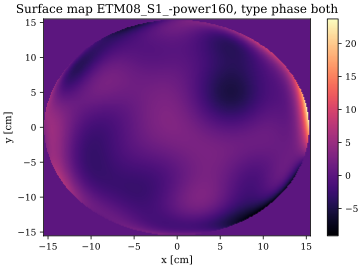

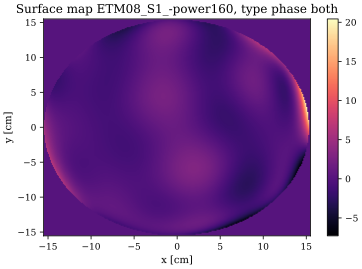

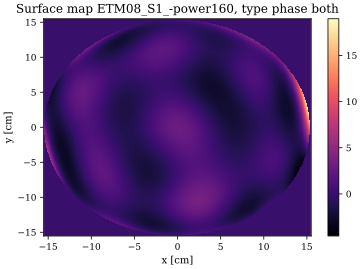

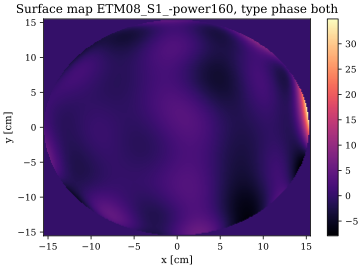

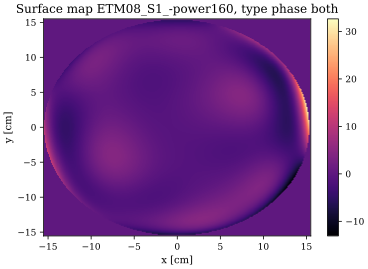

In [5]:
# plot first five above maps
for i in range(5):
    smap=pkm.read_map(f'randommaps/randommap{i}.txt', mapFormat='finesse')
    fig1 = smap.plot()